In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import os 

In [3]:
from glob import glob

In [4]:
files = ['./train_set/00/*','./train_set/01/*','./train_set/02/*','./train_set/03/*','./train_set/04/*','./train_set/05/*','./train_set/06/*','./train_set/07/*','./train_set/08/*','./train_set/09/*','./train_set/10/*']

In [5]:
def get_training_data(file_array: list):
    training_data = []
   
    #looping through files array
    for file in file_array:
        #getting the image data
        image = tf.keras.utils.load_img(file, grayscale=False, color_mode='grayscale', target_size=None,interpolation='nearest')
        #converting everything to numpy array
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        input_arr = np.array([input_arr]) 
        #normalize the array to a float from 0 to 1
        input_arr = input_arr/255
        #add dice image to training data
        training_data.append(input_arr[0])

    dices_array = np.array(training_data)
    return dices_array



In [6]:

def plot_history(history : tf.keras.callbacks.History):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')




In [7]:
#getting all the dices from the files
def get_all_dices(files: list):
    dices = []
    for file in files:
        f = glob(file)
        dices.append(get_training_data(f))
    return dices

In [8]:
dices = get_all_dices(files)

In [9]:
for i in dices:
    print(i.shape)

(737, 128, 128, 1)
(540, 128, 128, 1)
(484, 128, 128, 1)
(606, 128, 128, 1)
(624, 128, 128, 1)
(932, 128, 128, 1)
(906, 128, 128, 1)
(413, 128, 128, 1)
(398, 128, 128, 1)
(511, 128, 128, 1)
(420, 128, 128, 1)


In [10]:
#normalizing the amount of dices
_MAX_SAMPLES = 398
_dices = []
for dice in dices:
    _dices.append(dice[:_MAX_SAMPLES])

In [11]:
#getting all the labels for this training
def get_labels(max):
    labels = []
    for i in range(11):
        for j in range(max):
            labels.append(i)
    arr = np.array(labels)
    arr = arr.reshape((-1,1))
    return arr



In [12]:
def stack_training_data(_dices: list):
    training_data = np.concatenate([_dices[0],_dices[1]])
    for i in range(2,11):
        training_data = np.concatenate([training_data,_dices[i]])
    return training_data

In [13]:
#getting the labels for the training data
labels = get_labels(_MAX_SAMPLES)
labels.shape

(4378, 1)

In [14]:
labels

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [10],
       [10],
       [10]])

In [15]:
#getting all the training data
_training_data = stack_training_data(_dices)
_training_data.shape

(4378, 128, 128, 1)

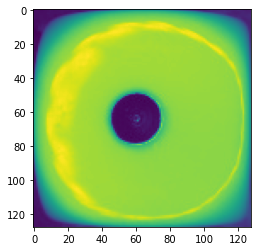

In [16]:
plt.imshow(_training_data[0])

In [17]:
_training_data[0].shape

(128, 128, 1)

In [18]:
#getting the train and validation data
from sklearn.model_selection import train_test_split
train_val_dice, test_dice, train_val_labels, test_labels = train_test_split(
    _training_data, 
    labels,
    test_size=0.5, 
    random_state=42, 
    shuffle=True
)

train_dice, val_dice, train_labels, val_labels = train_test_split(
    train_val_dice, 
    train_val_labels,
    test_size=0.5, 
    random_state=42, 
    shuffle=True
)


In [19]:
print("train_drawings shape : ", train_dice.shape)
print("val_drawings shape : ", val_dice.shape)
print("test_drawings shape : ", test_dice.shape)

print("train_labels shape : ", train_labels.shape)
print("val_labels shape : ", val_labels.shape)
print("test_labels shape : ", test_labels.shape)

train_drawings shape :  (1094, 128, 128, 1)
val_drawings shape :  (1095, 128, 128, 1)
test_drawings shape :  (2189, 128, 128, 1)
train_labels shape :  (1094, 1)
val_labels shape :  (1095, 1)
test_labels shape :  (2189, 1)


In [20]:
#parameters
input_size = 128
filter = 32

strides = (2, 2)
pool_size = (2,2)
kernel_size = (4,4)

In [27]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(filters=32,1,activation='relu',input_shape=(128,128,1)),
    

    layers.MaxPooling2D(pool_size=pool_size),
    #layers.Conv2D(filters=16,kernel_size=kernel_size,activation='relu'),
    

    #layers.MaxPooling2D(pool_size=pool_size),
    
    layers.Dense(128,activation='relu')

])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 125, 125, 32)      544       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [29]:
model.fit(train_dice,train_labels,epochs=6,validation_data=(val_dice,val_labels))

Epoch 1/6


InvalidArgumentError:  required broadcastable shapes
	 [[node Equal
 (defined at C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\metrics.py:3609)
]] [Op:__inference_train_function_1922]

Errors may have originated from an input operation.
Input Source operations connected to node Equal:
In[0] Cast_1 (defined at C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\metrics.py:716)	
In[1] Cast_2 (defined at C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\metrics.py:3607)

Operation defined at: (most recent call last)
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\Seba\AppData\Local\Temp/ipykernel_12688/2356308370.py", line 1, in <module>
>>>     model.fit(train_dice,train_labels,epochs=6,validation_data=(val_dice,val_labels))
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\engine\training.py", line 817, in train_step
>>>     self.compiled_metrics.update_state(y, y_pred, sample_weight)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\engine\compile_utils.py", line 460, in update_state
>>>     metric_obj.update_state(y_t, y_p, sample_weight=mask)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\utils\metrics_utils.py", line 73, in decorated
>>>     update_op = update_state_fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\metrics.py", line 177, in update_state_fn
>>>     return ag_update_state(*args, **kwargs)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\metrics.py", line 725, in update_state
>>>     matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "C:\Users\Seba\anaconda3\envs\gpu_tf\lib\site-packages\keras\metrics.py", line 3609, in sparse_categorical_accuracy
>>>     return tf.cast(tf.equal(y_true, y_pred), backend.floatx())
>>> 

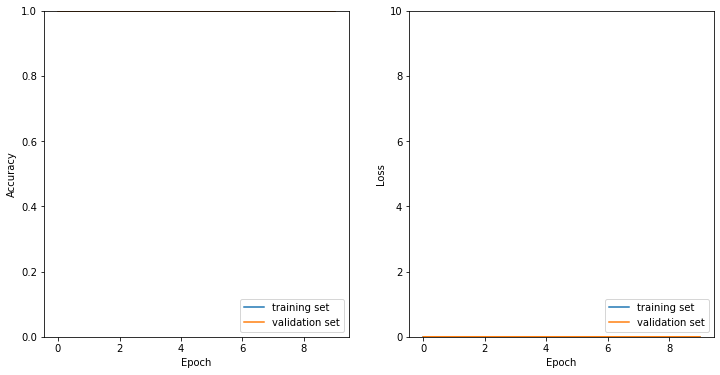

In [157]:
plot_history(history)

In [158]:
evaluation = model.evaluate(test_drawings,test_labels)

7/7 [==============================] - 0s 40ms/step - loss: 0.0017 - accuracy: 1.0000
